In [1]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ( 
    accuracy_score, 
    classification_report, 
    ConfusionMatrixDisplay
)
import tensorflow as tf
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

2025-03-11 03:45:52.898610: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-11 03:45:53.248324: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-11 03:45:53.526548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741664753.811538   78759 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741664753.876594   78759 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 03:45:54.594071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
df_raw = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/machine-learning-content/master/assets/spam.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
df_raw.sample(10, random_state=2025)

,Category,Message
2349,ham,That seems unnecessarily affectionate
5397,ham,That's necessarily respectful
4028,ham,"Yes, princess. Are you going to make me moan?"
3165,ham,TODAY is Sorry day.! If ever i was angry with ...
2738,ham,Hi Chachi tried calling u now unable to reach ...
2504,ham,Fwiw the reason I'm only around when it's time...
378,ham,Well there's not a lot of things happening in ...
3799,ham,"Feb &lt;#&gt; is ""I LOVE U"" day. Send dis to..."
5138,ham,Yup... I havent been there before... You want ...
4086,spam,Orange brings you ringtones from all time Char...


In [21]:
df_baking = df_raw.copy()
df_baking = df_baking.drop_duplicates()
df_baking['text'] = (
    df_baking['Message']
    .str.replace('://',' ')
    .str.replace('.',' ')
    .str.replace('/',' ')
    .str.replace('-',' ')
)
df_baking = df_baking.reset_index(drop=True)
df_baking['spam'] = (df_baking['Category']=='spam').astype(bool)
df = df_baking.copy()
df

,Category,Message,text,spam
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy Available only ...",False
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,False
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,True
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,False
4,ham,"Nah I don't think he goes to usf, he lives aro...","Nah I don't think he goes to usf, he lives aro...",False
...,...,...,...,...
5152,spam,This is the 2nd time we have tried 2 contact u...,This is the 2nd time we have tried 2 contact u...,True
5153,ham,Will ü b going to esplanade fr home?,Will ü b going to esplanade fr home?,False
5154,ham,"Pity, * was in mood for that. So...any other s...","Pity, * was in mood for that So any other s...",False
5155,ham,The guy did some bitching but I acted like i'd...,The guy did some bitching but I acted like i'd...,False


In [22]:
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify= df['Category'],
    random_state=2025
)
df_train, df_val = train_test_split(
    df_train,
    test_size=0.2,
    stratify= df_train['Category'],
    random_state=2025
)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.shape, df_val.shape, df_test.shape

((3300, 4), (825, 4), (1032, 4))

In [23]:
df_train.describe().T

,count,unique,top,freq
Category,3300,2,ham,2890
Message,3300,3300,Aiyar dun disturb u liao... Thk u have lots 2 ...,1
text,3300,3300,Aiyar dun disturb u liao Thk u have lots 2 ...,1
spam,3300,2,False,2890


In [13]:
(
    df_train['text']
    .str.split(expand=True)
    .stack()
    .value_counts()[:20]
)

to      1276
you     1079
I        966
a        797
the      702
and      528
in       499
i        497
is       451
u        430
for      428
my       414
me       397
of       354
your     347
on       306
that     302
have     293
it       290
2        288
Name: count, dtype: int64

In [24]:
X_train = df_train['text']
y_train = df_train['spam']
X_val = df_val['text']
y_val = df_val['spam']
X_test = df_test['text']
y_test = df_test['spam']

In [25]:
vectorizer = TfidfVectorizer(max_features=1000,ngram_range=(1,2))
X_train_v = vectorizer.fit_transform(X_train).toarray()
X_val_v = vectorizer.transform(X_val).toarray()
X_test_v = vectorizer.transform(X_test).toarray()

In [26]:
X_train_v.shape

(3300, 1000)

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256,activation='relu',input_shape=(X_train_v.shape[1],)),
    tf.keras.layers.Dense(128,activation='relu'),
    #tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

/workspaces/4geeks_class/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,281 (1.10 MB)

 Trainable params: 289,281 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [29]:
history = model.fit(
    X_train_v,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val_v,y_val)
)

Epoch 1/50


207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8922 - loss: 0.3298 - precision: 0.5641 - recall: 0.1252 - val_accuracy: 0.9855 - val_loss: 0.0546 - val_precision: 0.9417 - val_recall: 0.9417
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9833 - loss: 0.0556 - precision: 0.9649 - recall: 0.9089 - val_accuracy: 0.9915 - val_loss: 0.0394 - val_precision: 0.9706 - val_recall: 0.9612
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9956 - loss: 0.0152 - precision: 0.9922 - recall: 0.9719 - val_accuracy: 0.9842 - val_loss: 0.0482 - val_precision: 0.9091 - val_recall: 0.9709
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9988 - loss: 0.0069 - precision: 1.0000 - recall: 0.9901 - val_accuracy: 0.9891 - val_loss: 0.0494 - val_precision: 0.9434 - val_recall: 0.9709
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9993 - loss: 0.0038 - precision: 1.0000 - recall: 0.9943 - val_accuracy: 0.9891 - val_loss: 0.0533 - val_

In [30]:
model.evaluate(X_test_v,y_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9720 - loss: 0.2491 - precision: 0.9215 - recall: 0.8631 


[0.19868679344654083, 0.979651153087616, 0.934959352016449, 0.8984375]

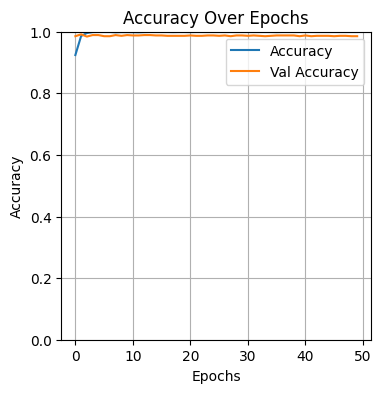

In [31]:
plt.figure(figsize=(4,4))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'],label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend()
plt.grid()
plt.show()